In [21]:
#import relavent packages

import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt

In [22]:
#import dataframe
df = pd.read_csv('../capstone_data/final_df.csv')

c:\users\sarah robinson\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (95,96,97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#drop unnecessary columns
drop_col = ['Fips', 'Area','State_code']
df = df.drop(columns= drop_col)

In [4]:
#convert income & age data to numeric
df.Income_Mean = pd.to_numeric(df.Income_Mean, errors='coerce')
df.Income_Median = pd.to_numeric(df.Income_Median, errors='coerce')
df.female_age_median = pd.to_numeric(df.female_age_median, errors = 'coerce')
df.all_age_median = pd.to_numeric(df.all_age_median, errors = 'coerce')
#change to numberic and fix column name
df['male_age_median'] = pd.to_numeric(df.male__age_median, errors = 'coerce')
df = df.drop(columns='male__age_median')

In [5]:
#set index
df = df.set_index(['Year','Zipcode'])

In [1]:
#first step ProfileReport, left out because of formatting. Relevant screen shots below. 
#pp.ProfileReport(df, check_correlation = False)

Pandas Profiling is a nice first step in EDA because it serves as detailed first glance at the data. From here I can identify concerns, and areas of interest for further analysis. 

What's concerning right away is the numer of zeros or missing values in many of the columns. It may be useful to ditch these columns in the future. 

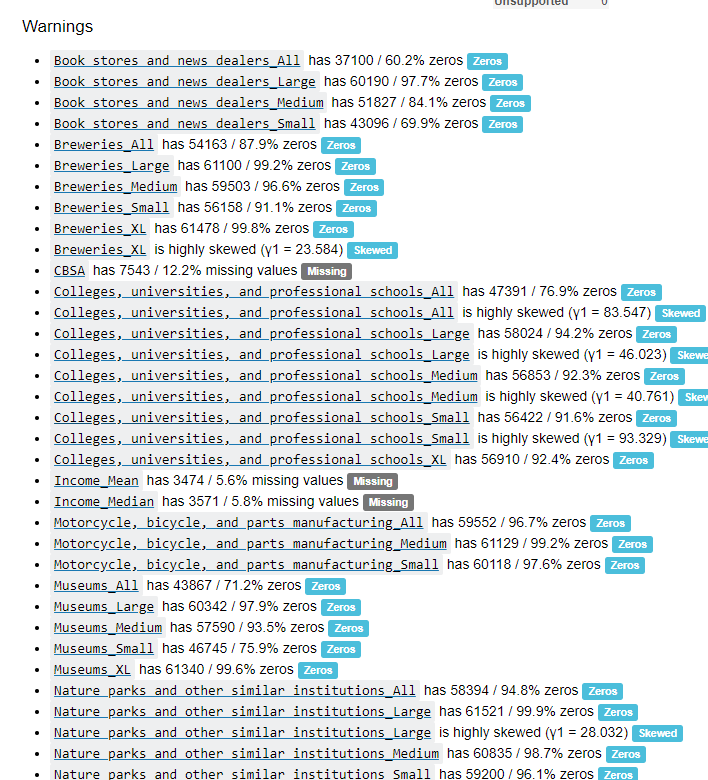

Another valuable observation, is the outliers serveral of the columns. In the GDP_per_capita column. This is apparent in both the histogram and the quantile statistics given in the details of the profile report. There is a small chunk of values far greater than 95% of the values. These values will be removed from the dataframe.

![image.png](pics/gdp_outlier.png)

The age columns also have values than do not make sense, like a median age of 6 years old. Outliers will need to be removed from these columns as well. Additionally, there is a high correlation between the age columns. This makes sense, as the female and median age values are a component of all_age_median.This may be something to watch out for. 

![image.png](pics/age_outlier.png)

Both income and population columns also have some extreme outliers to be removed. 

![image.png](pics/income_outlier.png)

Another potential issue is that Percent_GDP_1 is recognized as a boolean, because Industry 1 is a value for all industries and the percentage will always be 1. This column will be deleted.  

![image.png](pics/gdp1_bool.png)

In [8]:
#remove gdp percent for industry 1 column
df = df.drop(columns = 'Percent GDP_1')

In [7]:
#create remove outlier function
def remove_outliers(df, df_target, low, high):
    quant_df = df_target.quantile([low, high])
    for col in quant_df.columns:
        df = df.loc[(df[col] < quant_df[col][high])& (df[col]> quant_df[col][low])]
    
    return df

In [10]:
#remove outliers from age, gdp per capita, income, and population columns columns
df_target = df[['all_age_median','female_age_median', 'male_age_median', 'GDP_per_capita', 'Income_Median', 'Income_Mean', 'Population']]
df = remove_outliers(df, df_target, 0.025, 0.975)

In [11]:
len(df)

47116

In [2]:
#Use another ProfileReport to see changes
#pp.ProfileReport(df, check_correlation = False)

![image.png](pics/age_norm.png) 
![image.png](pics/income_norm.png)
![image.png](pics/pop_norm.png)

Now age, income, and population columns have more 'normal' looking distributions. GDP_percapita still has a pretty wonky looking distribution. 

In [13]:
#check top correlations
df_corr = df.corr()
small_brew_corr = df_corr.Breweries_Small
small_brew_corr.abs().nlargest(n=30)

Breweries_Small                                         1.000000
Breweries_All                                           0.856891
Breweries_Medium                                        0.172269
Sporting goods stores_All                               0.141216
Sporting goods stores_Small                             0.126590
Motorcycle, bicycle, and parts manufacturing_All        0.120341
Sporting goods stores_Medium                            0.109569
Motorcycle, bicycle, and parts manufacturing_Small      0.105083
Breweries_Large                                         0.102071
Population                                              0.098640
Museums_All                                             0.096764
Museums_Medium                                          0.082160
Percent GDP_88                                          0.075601
Book stores and news dealers_All                        0.072637
Motorcycle, bicycle, and parts manufacturing_Medium     0.071414
Percent GDP_46           

It makes sense that Breweries_All would have the highest (after itself) correlation, since Breweries_Small is a component of Breweries_All. I may want to consider removing this value. 

I find it interesting that the number of establishments of other businesses have the top correlations. I included data from these industriees because I thought they may be related, but I am concerned that the correlation is due to the high percentage of zeros in these columns. I would have hypothesised that the demographic data, such as age and income, would have made it higher on the list. 

I also think its noteworthy that Income_Mean has a higher correlation than Income_Median. Likewise with female_age_median and male_age_median. 

## relationship of select variables to small breweries

### Q. What is the relationship between the population and number of small breweries?

c:\users\sarah robinson\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


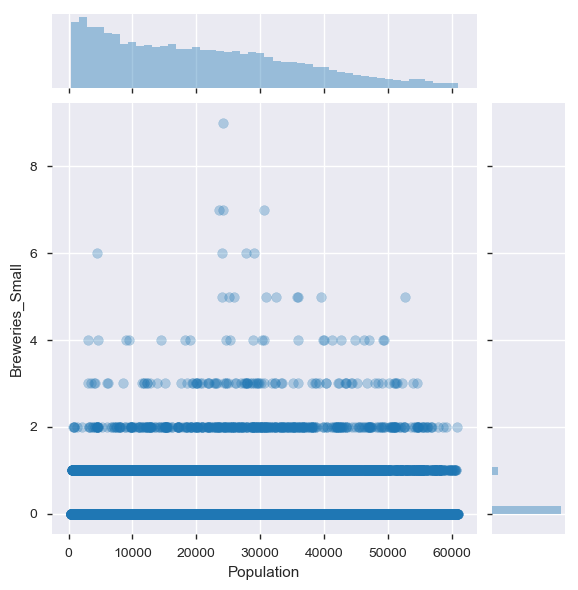

In [14]:
sns.jointplot(x=df.Population, y = df.Breweries_Small, kind = 'scatter', alpha = .3)

#### Insights: It is interesting that population has only a small correlation to the number of breweries, with r = 0.098. I had hypothesized that population would be strongly correlated with number of breweries, with more people meaning more potential business. 

### Q. How does GDP per capita relate to the number of small breweries in an area? 


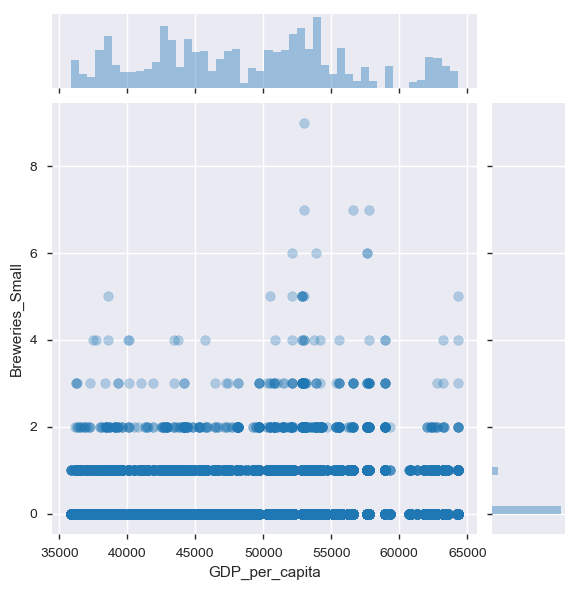

In [17]:
sns.jointplot(x=df.GDP_per_capita, y=df.Breweries_Small, kind = 'scatter', alpha = .3)


#### Insights: There is seems to be a clustering of breweries in the middle, and normal(ish) distribution. Has a very, very small positive correlation. This aligns with what I would expect, that a higher gdp would suppport more breweries. There seems to be a sweet spot in the middle. I wonder if highly productive economies are not able to support breweries, or vice versa.

### Q. What is the relationship between median age, and the number of small breweries in an area?

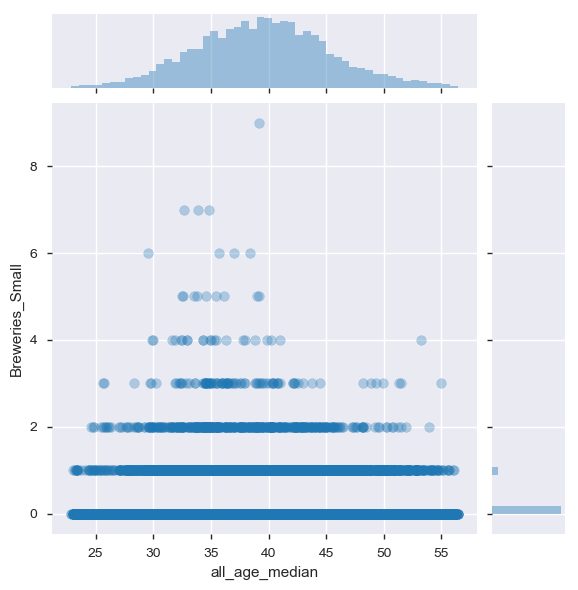

In [16]:
sns.jointplot(x= df.all_age_median, y=df.Breweries_Small, kind = 'scatter', alpha = .3 )

#### Insights: A pretty obvious normal distribution, and a negative correlation between median age and small breweries. This aligns with what I would expect, that there are more breweries where there are more young people. 

### Q. Is there a relationship between the number of higher education intitutions and small breweries in an area?

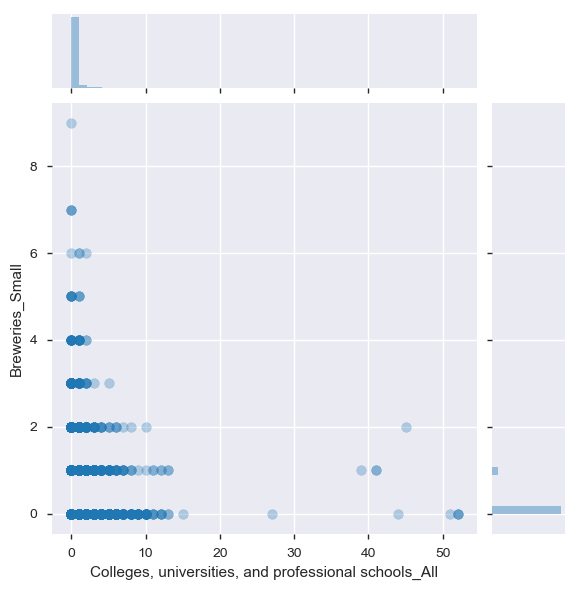

In [15]:
sns.jointplot(x = df['Colleges, universities, and professional schools_All'], y=df.Breweries_Small, kind='scatter', alpha = .3)

#### Insights: Visually, it would appear that there is a steep negative relationship between colleges and breweries. This is the opposite of what I would expect to find, and opposite of what is reflected by the r value, Which indicates that there is slightly positive relationship between colleges and breweries. Weird.

### Q. What is the relationship between median income and number of small breweries?

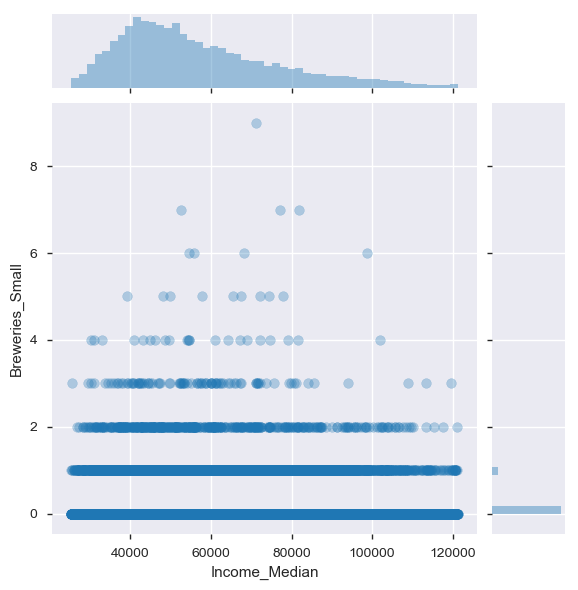

In [19]:
sns.jointplot(x=df['Income_Median'], y=df.Breweries_Small, kind='scatter', alpha = .3)

#### Insights: The Distribution is skewed torwards the left. It looks like there is a sweet spot for income, right around 50,000 dollars. 

### Q. Does having larger breweries in the area affect the number of small breweries in that area? 

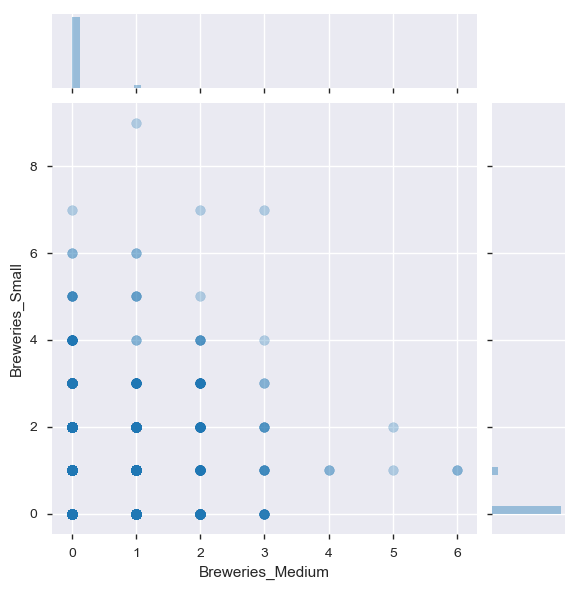

In [18]:
sns.jointplot(x=df['Breweries_Medium'], y=df.Breweries_Small, kind='scatter', alpha =.3)

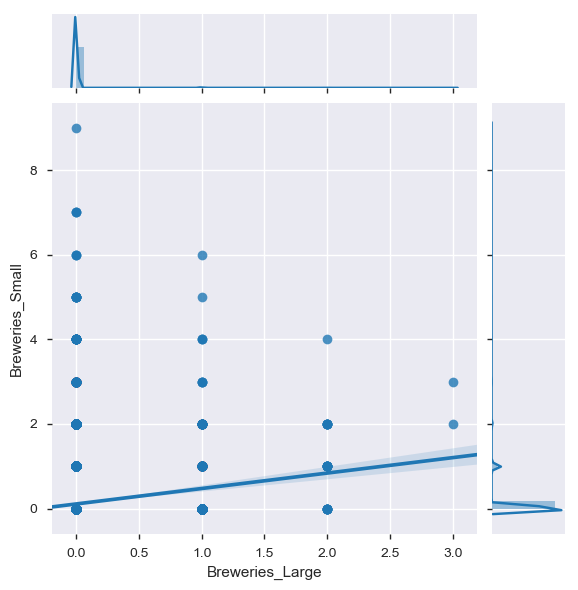

In [20]:
sns.jointplot(x=df.Breweries_Large, y=df.Breweries_Small, kind = 'reg')


#### Insights: Even though these appear to have a negative relationship, visually, both medium, and large breweries have a very slight positive correlation with small breweries. 

### General Conclusions: The p value on all examined coefficients, except for medium breweries, is much less than 0.05, denoting that all for all of those variables, the coefficient is highly significant.  Hopefully, this is indication that a successful model, prediting the number of small breweries in an area, can be built using these variables and more. 